In [12]:
import warnings
warnings.filterwarnings('ignore')


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import plotly.express as px
import kagglehub


In [17]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

# Paths to the dataset
dataset_path = f"{path}/animals/animals"
labels_file = f"{path}/name of the animals.txt"

# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().splitlines()

# Display the first few animal names to confirm loading
print(animal_names)


['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [3]:
# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

# Plot distribution of animal classes
fig = px.bar(animal_counts_df, x='Animal', y='Count', title='Distribution of Animal Classes',
             labels={'Animal': 'Animal', 'Count': 'Number of Images'}, color='Count', color_continuous_scale='Viridis',
             template='plotly_dark')
fig.update_layout(title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18,
                  font=dict(family="Arial, sans-serif", size=14))
fig.show()


In [4]:
# Image Preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [10]:
# Load the EfficientNetB3 model with pre-trained weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers of EfficientNetB3 for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(animal_names), activation='softmax')
])

# Compile the model with a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model with data augmentation and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler, early_stopping])

# Save the trained model
model.save('animal_classification_model')


Epoch 1/50
540/540 [==============================] - 54s 99ms/step - loss: 0.6161 - accuracy: 0.8468 - val_loss: 0.4576 - val_accuracy: 0.8917 - lr: 1.0000e-05
Epoch 2/50
540/540 [==============================] - 49s 91ms/step - loss: 0.5951 - accuracy: 0.8486 - val_loss: 0.4730 - val_accuracy: 0.8963 - lr: 1.0000e-05
Epoch 3/50
540/540 [==============================] - 48s 89ms/step - loss: 0.5394 - accuracy: 0.8697 - val_loss: 0.5035 - val_accuracy: 0.8778 - lr: 1.0000e-05
Epoch 4/50
540/540 [==============================] - 48s 89ms/step - loss: 0.5072 - accuracy: 0.8748 - val_loss: 0.3985 - val_accuracy: 0.9065 - lr: 1.0000e-05
Epoch 5/50
540/540 [==============================] - 48s 89ms/step - loss: 0.4773 - accuracy: 0.8817 - val_loss: 0.3834 - val_accuracy: 0.9120 - lr: 1.0000e-05
Epoch 6/50
540/540 [==============================] - 48s 88ms/step - loss: 0.4533 - accuracy: 0.8819 - val_loss: 0.3970 - val_accuracy: 0.9111 - lr: 1.0000e-05
Epoch 7/50
540/540 [==============

INFO:tensorflow:Assets written to: animal_classification_model\assets


INFO:tensorflow:Assets written to: animal_classification_model\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [15]:
# Plot training and validation accuracy
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy'])+1)), y=history.history['accuracy'], mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy'])+1)), y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14), template='plotly_dark')
fig.show()

# Plot training and validation loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss'])+1)), y=history.history['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss'])+1)), y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss', title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14), template='plotly_dark')
fig.show()


34/34 [==============================] - 4s 78ms/step
                precision    recall  f1-score   support

      antelope       0.75      0.82      0.78        11
        badger       0.95      1.00      0.97        19
           bat       1.00      0.82      0.90        11
          bear       1.00      0.85      0.92        13
           bee       1.00      1.00      1.00        16
        beetle       0.91      0.91      0.91        11
         bison       0.91      0.83      0.87        12
          boar       0.80      1.00      0.89        16
     butterfly       1.00      1.00      1.00        12
           cat       1.00      0.92      0.96        13
   caterpillar       0.92      1.00      0.96        11
    chimpanzee       1.00      1.00      1.00        12
     cockroach       1.00      1.00      1.00        15
           cow       0.91      0.67      0.77        15
        coyote       0.85      1.00      0.92        11
          crab       1.00      1.00      1.00    

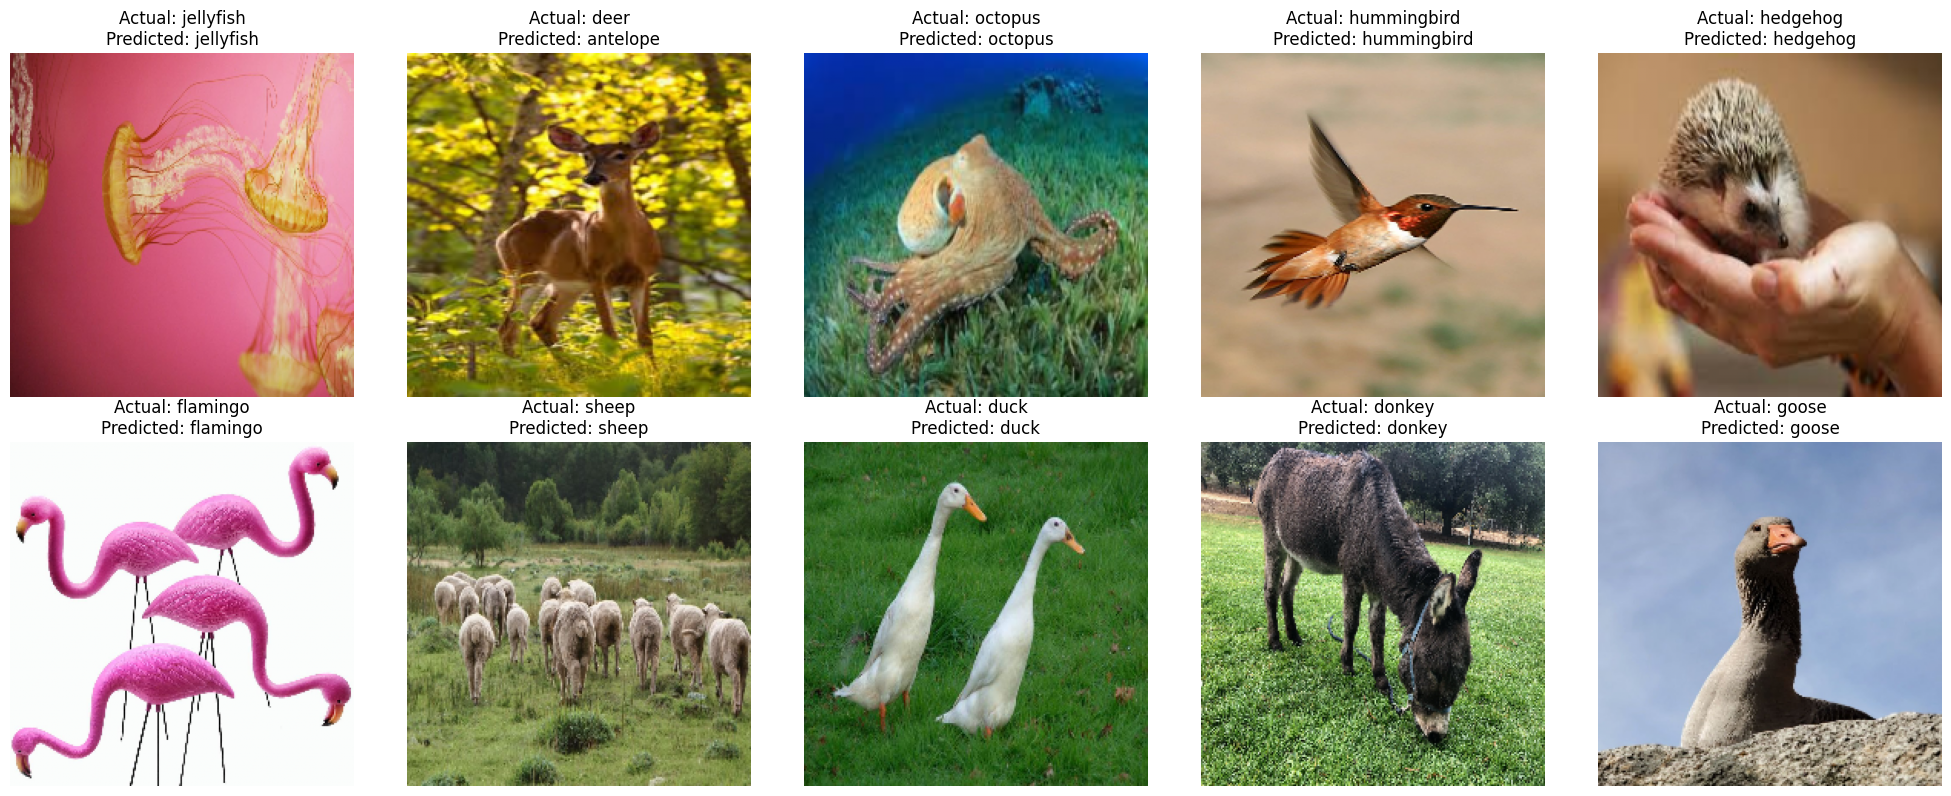

In [16]:
# Evaluate the model and display the classification report
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f'Actual: {label_encoder.inverse_transform([y_test[i]])[0]}\nPredicted: {label_encoder.inverse_transform([y_pred[i]])[0]}')
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the model using tf.saved_model.load
model = tf.saved_model.load('animal_classification_model')

# List of animal names (labels)
animal_names = [
    'antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 
    'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 
    'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 
    'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 
    'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 
    'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 
    'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 
    'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 
    'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 
    'wolf', 'wombat', 'woodpecker', 'zebra'
]

# Function to preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Adjust to the model's input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.astype('float32')  # Ensure data type is float32
    return image

# Function to predict the animal from an image
def predict_animal(image_path, model, animal_names):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    
    # Make a prediction
    predictions = model(preprocessed_image)  # Directly call the model as a function
    
    # Convert the prediction tensor to a numpy array and get the index of the highest confidence
    predictions = predictions.numpy()
    predicted_index = np.argmax(predictions)
    
    # Map the index to the corresponding animal name
    predicted_animal = animal_names[predicted_index]
    
    return predicted_animal

# Example usage
image_path = 'images.jpeg' 
predicted_animal = predict_animal(image_path, model, animal_names)
print("Predicted Animal:", predicted_animal)


Predicted Animal: mouse


In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model('animal_classification_model')
tflite_model = converter.convert()
with open('animal_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [32]:
import tensorflow as tf
import numpy as np
import cv2

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='animal_classification_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# List of animal names (labels)
animal_names = [
    'antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 
    'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 
    'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 
    'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 
    'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 
    'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 
    'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 
    'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 
    'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 
    'wolf', 'wombat', 'woodpecker', 'zebra'
]

# Function to preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Adjust to the model's input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.astype('float32')  # Ensure data type is float32
    return image

# Function to predict the animal from an image using the TFLite model
def predict_animal(image_path, interpreter, animal_names):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    # Run inference
    interpreter.invoke()

    # Get the output tensor and find the index of the highest probability
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    predicted_index = np.argmax(predictions)

    # Map the index to the corresponding animal name
    predicted_animal = animal_names[predicted_index]
    
    return predicted_animal

# Example usage
image_path = 'images (1).jpeg'
predicted_animal = predict_animal(image_path, interpreter, animal_names)
print("Predicted Animal:", predicted_animal)


Predicted Animal: cat
